In [89]:
### Extra code to reuse

## Exporting data to CSV
# combined_data.to_csv('file_name.csv')

## Finding what the Data Type a column is.
# data_type = IMDb_Basics['isAdult'].dtype
# print(data_type)

## Filtering dataframes for a specific values
# filtered_df = IMDB_Basics[IMDB_Basics['primaryTitle'].str.contains('Bond', case=False, na=False)]
# print(filtered_df)

# Optionally save the combined dataframe to a new CSV file
# output_file = path_to_files + 'combined_data.csv'
# combined_df.to_csv(output_file, index=False)
# print(f"Combined CSV saved to {output_file}")

# Code to troubleshoot date columns

# 1. Check for NaT values:
# If you used errors='coerce' during the conversion, you can check for NaT values, which would indicate conversion failures.
# nat_counts = all_stocks['Date'].isna().sum()
# print(f"Number of NaT values in 'Date': {nat_counts}")

# 2. Check the range of dates:
# Look at the minimum and maximum values to ensure they are within expected bounds.
# print("Earliest date:", all_stocks['Date'].min())
# print("Latest date:", all_stocks['Date'].max())

# 3. Sample random dates:
# Random sampling of dates can give you a quick spot check to see if dates look correctly formatted.
# print(all_stocks['Date'].sample(10))

# 4. Validate with known dates:
# If you know certain dates should exist in the dataset, check those specifically.
# known_dates = ["1997-05-15", "2005-07-08"]  # Example dates you expect to find
# for date in known_dates:
#     if pd.to_datetime(date) not in all_stocks['Date'].values:
#         print(f"Date {date} is not found or incorrectly formatted.")
#     else:
#         print(f"Date {date} is correctly formatted.")

# 5. Check for duplicates:
# Ensuring that there are no duplicate dates which could suggest an issue with the conversion.
# duplicate_dates = all_stocks['Date'].duplicated().sum()
# print(f"Number of duplicate dates: {duplicate_dates}")

## Remove duplicate rows based on the 'Release' column, keeping the first occurrence
# no_duplicates = no_duplicates.drop_duplicates(subset='Release', keep='first')

# # Remove the dollar sign and commas, then convert the column to numeric values
# no_duplicates['Gross'] = no_duplicates['Gross'].replace(r'[\$,]', '', regex=True).astype(float)
# # Calculate the mean of the 'Gross' column after conversion
# gross_mean = no_duplicates['Gross'].mean()
# # Now 'gross_mean' contains the average of the 'Gross' column as a float
# print(gross_mean)

<span style="color:green">

# Meeting notes

## Meeting 1 Feedback- In-Progress
Project Proposal Meeting notes
 Outcome variable is Stock returns
We cannot have 2 different observations we could use weighted average or just an average of the 2 movies. Because in a month there could be 2 movies launched by Disney and we need to be able to see what is the causal but with just 1 movie.
We should do quarterly and then do monthly. So this way we will be able to see a change in the response from investors and the market.
I will determine the number of years of data according to the number of observations.
(I can include Text analysis based on individual people’s reviews for each movies. I can use this for my Capstone project. I can do analysis on if someone left a good review score and bad text comments.)

## Meeting 2 Feedback- 
- I will do my analysis on month to month basis on the stock prices of companies.
- I should also add another Index price for Media Companies along side the stocks to control for that variable.
- Y is the stock price a month after the release minus the stock price at the month of the release.
- As a control I can include, Vanguard 500 and also the Media Company Index. I can include the changes in it than the absolute values.
- 

</span>

<span style="color:red">

# Problems to be solved

1. For the economic indicators the data spans for each quarter in a year and not monthly. What do we do about that?
    - We can duplicate the same value for the next 3 months.
2. For the Stocks dataset what columns do we need? Do we need open, close? This way I can reduce the size of the model.
    - Use the close price for all companies.
3. In the IMDb final table I still need to add the release date.
    - Get the format to be the same as the other tables so I can join the data.
4. The lions gate company stock that I am using only goes from 2017 and forward. Should we remove that company or no?
5. Also should we remove companies like ATT because that is not a media company rather they own a media company. Is that a problem?
</span>

# Setting File location

In [90]:
import os
import glob
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

os.chdir('/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data')

---------------

# 1. Loading and Modeling Stocks Data

In [91]:
# 1: Stocks
Amazon_Stock = pd.read_csv('Amazon Stock.csv')
Apple_Stock = pd.read_csv('Apple Stock.csv')
ATT_Stock = pd.read_csv('AT&T Stock.csv')
Comcast_Stock = pd.read_csv('Comcast Stock.csv')
Lions_Gate_Historical_B = pd.read_csv('Lions Gate Historical.csv')
Netflix_Stock_Data = pd.read_csv('Netflix Stock Data.csv')
Paramount_Global_Historical_Prices = pd.read_csv('Paramount Global Historical Prices.csv')
Sony_Stock = pd.read_csv('Sony Stock.csv')
The_Walt_Disney_Company_Historical_Prices = pd.read_csv('The Walt Disney Company Historical Prices.csv')
Warner_Bros_Discovery = pd.read_csv('Warner Bros Discovery.csv')
Vanguard_500_Historical = pd.read_csv('Vanguard 500 Historical.csv') #this is here as a control variable for the overall market

In [135]:
# Adding company to each individual stick dataframe to the respective company name.
Amazon_Stock['Company'] = 'Amazon'
Apple_Stock['Company'] = 'Apple'
ATT_Stock['Company'] = 'AT&T'
Comcast_Stock['Company'] = 'Comcast'
Lions_Gate_Historical_B['Company'] = 'Lions Gate'
Netflix_Stock_Data['Company'] = 'Netflix'
Paramount_Global_Historical_Prices['Company'] = 'Paramount Global'
Sony_Stock['Company'] = 'Sony'
The_Walt_Disney_Company_Historical_Prices['Company'] = 'Walt Disney'
Warner_Bros_Discovery['Company'] = 'Warner Bros Discovery'
Vanguard_500_Historical['Company'] = 'Vanguard_500_Historical'

# Convert 'Date' columns to datetime for all dataframes before merging
# Note: If your date formats are inconsistent, you may need to handle them individually.
company_stocks = [Amazon_Stock, Apple_Stock, ATT_Stock, Comcast_Stock, Lions_Gate_Historical_B, Netflix_Stock_Data, Paramount_Global_Historical_Prices, Sony_Stock, The_Walt_Disney_Company_Historical_Prices, Warner_Bros_Discovery, Vanguard_500_Historical]

for stock_df in company_stocks:
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Define the list of company names
company_names = ['Amazon', 'Apple', 'AT&T', 'Comcast', 'Lions Gate', 'Netflix', 'Paramount Global', 'Sony', 'Walt Disney', 'Warner Bros Discovery', 'Vanguard 500']

# Initialize the combined DataFrame
all_stocks = pd.DataFrame()

# Loop through each company DataFrame
for stock_df, company_name in zip(company_stocks, company_names):
    # Rename columns to include the company name (excluding 'Date')
    cols_to_rename = {col: f"{col}_{company_name}" for col in stock_df.columns if col != 'Date'}
    df_renamed = stock_df.rename(columns=cols_to_rename)
    
    # Merge with the combined DataFrame
    if all_stocks.empty:
        all_stocks = df_renamed
    else:
        all_stocks = all_stocks.merge(df_renamed, on='Date', how='outer')

# all_stocks now contains all the data with renamed columns and one 'Date' column
all_stocks.sort_values('Date', inplace=True)

# Formatting the date column to the appropriate date type.
def parse_dates(date):
    for fmt in ("%Y-%m-%d", "%m/%d/%y"):  # Add or adjust formats as needed
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # return Not a Time for unparseable formats

all_stocks['Date'] = all_stocks['Date'].apply(parse_dates)

In [136]:
all_stocks.head(10)

,Date,Open_Amazon,High_Amazon,Low_Amazon,Close_Amazon,Adj Close_Amazon,Volume_Amazon,Company_Amazon,Open_Apple,High_Apple,...,Adj Close_Warner Bros Discovery,Volume_Warner Bros Discovery,Company_Warner Bros Discovery,Open_Vanguard 500,High_Vanguard 500,Low_Vanguard 500,Close_Vanguard 500,Adj Close_Vanguard 500,Volume_Vanguard 500,Company_Vanguard 500
12800,1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12801,1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12802,1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12803,1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12804,1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12805,1962-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12806,1962-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12807,1962-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12808,1962-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12809,1962-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# Use the provided parse_dates function to convert dates
all_stocks['Date'] = all_stocks['Date'].apply(parse_dates)

# Now set 'Date' as the index
all_stocks.set_index('Date', inplace=True)

# Define the columns you want to include in the average calculation
# You can exclude non-numeric columns or columns that you don't want to average
numeric_columns = all_stocks.select_dtypes(include=['float64', 'int64']).columns

# Resample to monthly frequency, calculating the mean for each group
stocks_monthly_avg = all_stocks[numeric_columns].resample('M').mean()

# Reset index to move 'Date' back to a column and format it as 'MM/YYYY'
stocks_monthly_avg.reset_index(inplace=True)
stocks_monthly_avg['Date'] = stocks_monthly_avg['Date'].dt.strftime('%m/%Y')

In [138]:
# List of keywords to search for in column names
keywords_to_drop = ['Low', 'High', 'Volume', 'Company', 'Open', 'Adj Close']

# Find the columns that contain any of the keywords
columns_to_drop = stocks_monthly_avg.filter(regex='|'.join(keywords_to_drop)).columns

# Drop these columns from the DataFrame
stocks_monthly_avg.drop(columns=columns_to_drop, inplace=True)

In [141]:
# Convert 'Date' to datetime format for filtering (assuming it is in the format MM/YYYY)
stocks_monthly_avg['Date'] = pd.to_datetime(stocks_monthly_avg['Date'], format='%m/%Y')

# Filter the DataFrame for dates greater than or equal to January 2014
stocks_monthly_avg = stocks_monthly_avg[stocks_monthly_avg['Date'] >= '2013-12-30']

# Convert 'Date' back to 'MM/YYYY' format after filtering
stocks_monthly_avg['Date'] = stocks_monthly_avg['Date'].dt.strftime('%m/%Y')

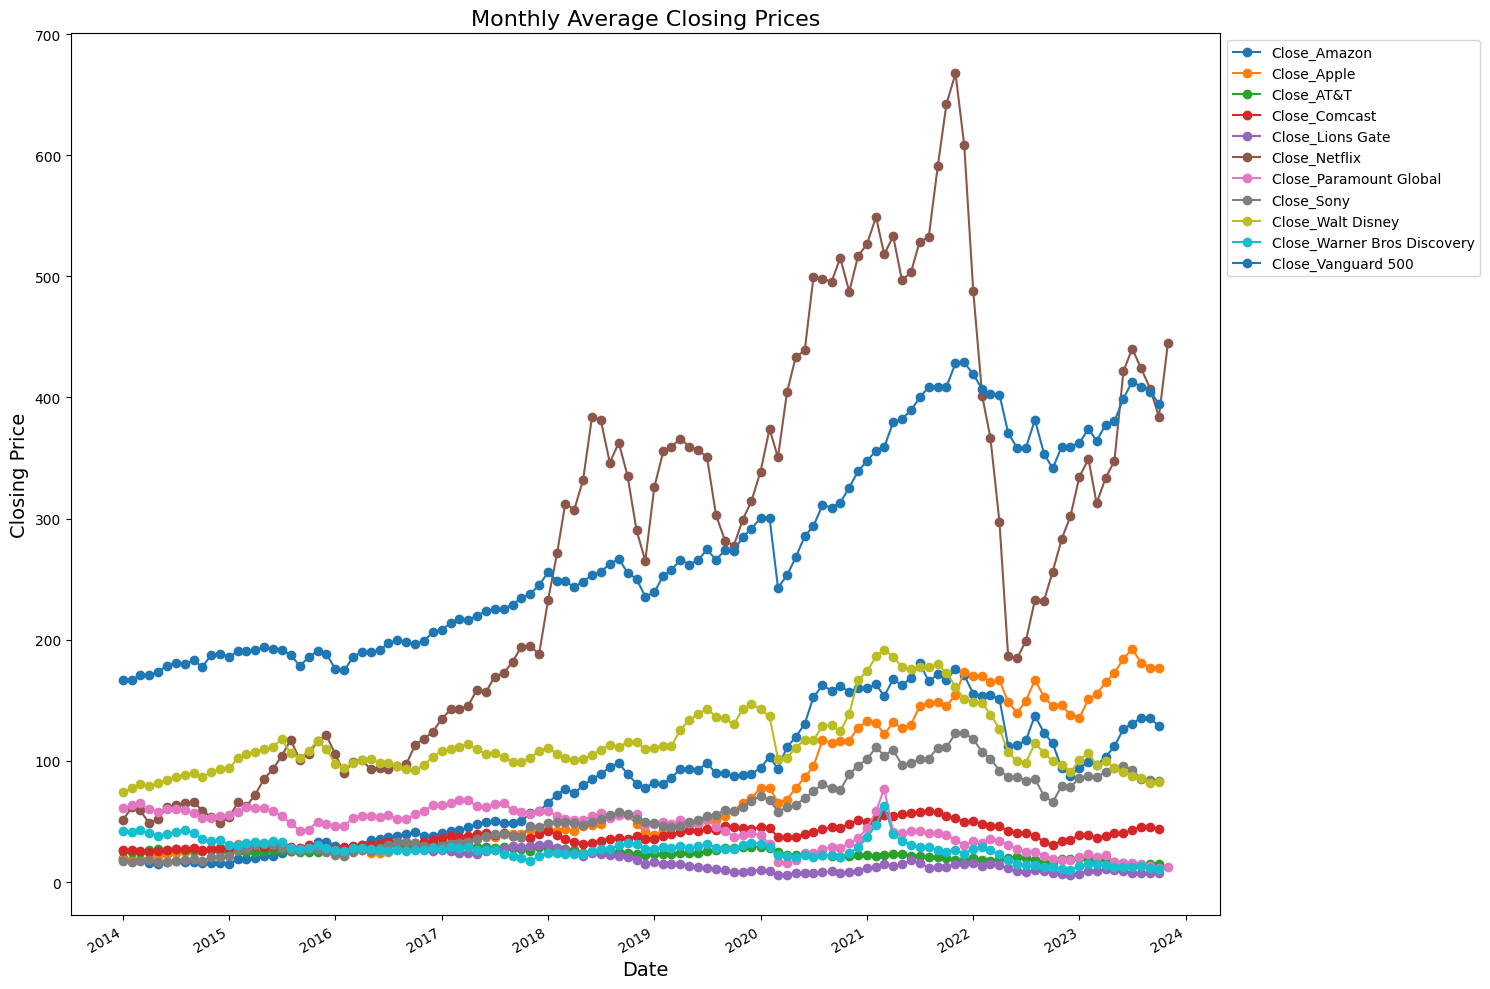

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Date' to datetime format for plotting, if not already done
stocks_monthly_avg['Date'] = pd.to_datetime(stocks_monthly_avg['Date'], format='%m/%Y')

# Sort the DataFrame by 'Date' to ensure the plot is in chronological order
stocks_monthly_avg.sort_values('Date', inplace=True)

# Set the figure size for better visibility
plt.figure(figsize=(15,10))

# Loop through each column except 'Date' to plot
for column in stocks_monthly_avg.columns:
    if column != 'Date' and 'Close' in column:  # Check if the column name contains 'Close'
        plt.plot(stocks_monthly_avg['Date'], stocks_monthly_avg[column], label=column, marker='o')

# Add labels, title, and legend
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.title('Monthly Average Closing Prices', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))  # Place legend outside the plot

# Rotate and align the tick labels
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()


In [142]:
stocks_monthly_avg.head(20)

,Date,Close_Amazon,Close_Apple,Close_AT&T,Close_Comcast,Close_Lions Gate,Close_Netflix,Close_Paramount Global,Close_Sony,Close_Walt Disney,Close_Warner Bros Discovery,Close_Vanguard 500
624,01/2014,19.743167,19.194490,25.557834,26.469762,NaN,51.304082,60.758572,17.042381,74.264285,42.071684,166.779048
625,02/2014,17.716842,18.806428,24.574654,26.391579,NaN,61.631278,63.270527,16.936316,77.578948,41.576796,166.606315
626,03/2014,18.131524,19.043367,25.143504,25.299762,NaN,59.264830,65.208571,17.774762,80.669523,42.798258,170.969049
627,04/2014,16.082072,19.324082,26.732844,25.020000,NaN,48.660476,59.904285,18.604286,79.282381,40.316081,170.696190
628,05/2014,15.147690,21.542704,27.073083,25.668810,NaN,51.775714,58.050476,16.797619,81.776190,38.404750,173.350476
629,06/2014,16.228667,22.971360,26.555532,26.405952,NaN,61.900680,60.613334,16.423333,83.970477,39.315279,178.695712
630,07/2014,16.995955,23.906477,27.102445,27.272046,NaN,63.202662,60.660455,17.026364,86.351363,41.266781,180.788182
631,08/2014,16.366595,24.609167,26.216012,27.039524,NaN,65.317211,59.310953,18.318572,88.579523,43.342145,180.025238
632,09/2014,16.515595,25.137143,26.467415,27.867381,NaN,66.116463,56.654762,18.707143,89.779523,40.298095,182.996191
633,10/2014,15.420522,25.424891,26.025877,26.452391,NaN,58.926149,52.484783,17.632174,86.976521,35.764783,177.526088


# Final Table name is <span style="color:red">stocks_monthly_avg</span>

---------------------

# 2. Loading and Modeling Economic Indicators

In [101]:
# Economic Indicators 
GDP = pd.read_csv('GDP.csv') # Billions of Dollars & Seasonally Adjusted Annual Rate
Unemployment_Rate = pd.read_csv('Unemployment Rate US.csv') # This is Percent & Seasonally Adjusted

In [66]:
#Renaming a column in the Unemployment table
Unemployment_Rate.rename(columns={'LRUNTTTTUSQ156S': 'Unemployment_rate'}, inplace=True)
# Unemployment_Rate.head()

# Convert the dictionaries to DataFrames
GDP = pd.DataFrame(GDP)
Unemployment = pd.DataFrame(Unemployment_Rate)

# Merge the DataFrames on the 'DATE' column
Economic_Indicators = GDP.merge(Unemployment, on='DATE', how='outer')

# Economic_Indicators.to_csv('file_name.csv')

In [67]:
Economic_Indicators.tail()

,DATE,GDP,Unemployment_rate
301,2022-04-01,25544.273,3.600000
302,2022-07-01,25994.639,3.566667
303,2022-10-01,26408.405,3.600000
304,2023-01-01,26813.601,3.500000
305,2023-04-01,27063.012,3.566667


In [68]:
# Convert 'DATE' to datetime format if it's not already
Economic_Indicators['DATE'] = pd.to_datetime(Economic_Indicators['DATE'])

# Format 'DATE' as 'MM/YYYY'
Economic_Indicators['DATE'] = Economic_Indicators['DATE'].dt.strftime('%m/%Y')

# Now 'DATE' will be in the 'MM/YYYY' format

In [69]:
# Renaming the 'DATE' column to 'Date'
Economic_Indicators.rename(columns={'DATE': 'Date'}, inplace=True)

In [146]:
# Convert 'Date' to datetime format for filtering (assuming it is in the format MM/YYYY)
Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'], format='%m/%Y')

# Filter the DataFrame for dates greater than or equal to January 2014
Economic_Indicators = Economic_Indicators[Economic_Indicators['Date'] >= '2013-12-30']

# Convert 'Date' back to 'MM/YYYY' format after filtering
Economic_Indicators['Date'] = Economic_Indicators['Date'].dt.strftime('%m/%Y')

In [148]:
Economic_Indicators.head()

,Date,GDP,Unemployment_rate
268,01/2014,17197.738,6.666667
269,04/2014,17518.508,6.200000
270,07/2014,17804.228,6.066667
271,10/2014,17912.079,5.700000
272,01/2015,18063.529,5.533333


/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_19147/3345362964.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'])


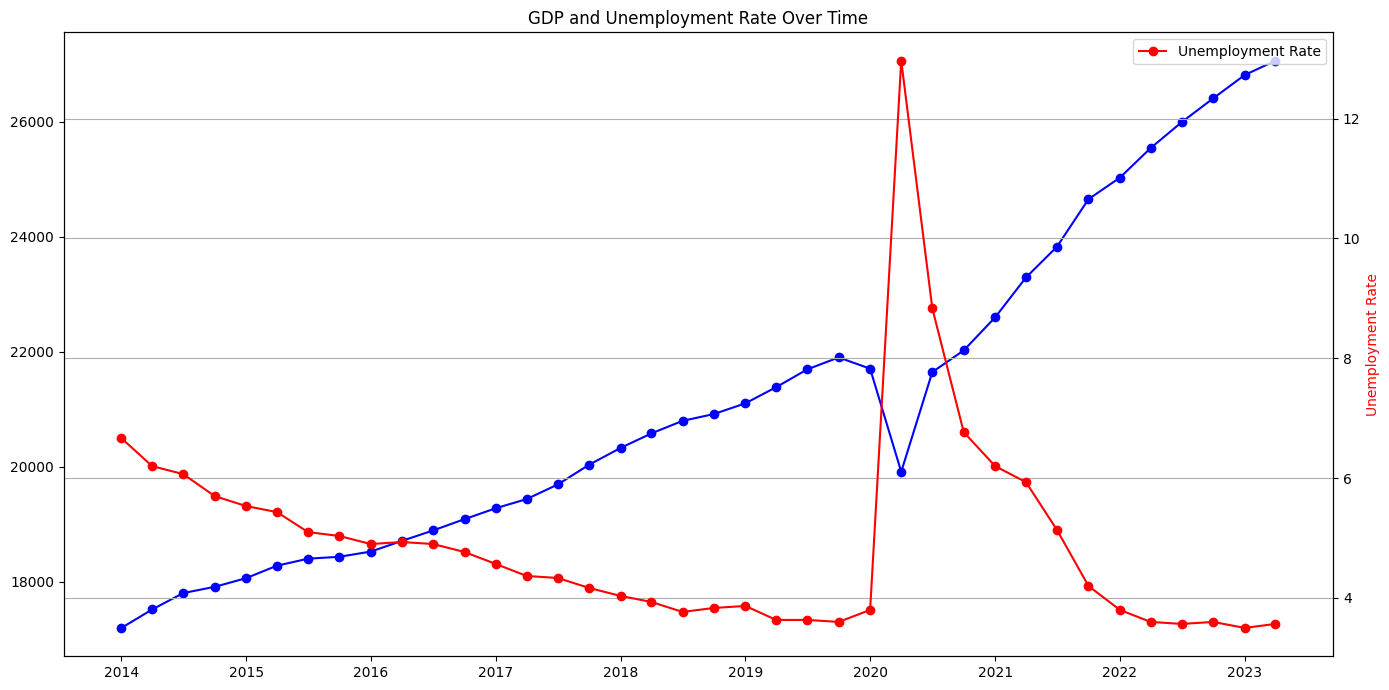

In [149]:
# Charting the Economic Indicators

Economic_Indicators = pd.DataFrame(Economic_Indicators)

# Convert 'DATE' to datetime if it's not already
Economic_Indicators['Date'] = pd.to_datetime(Economic_Indicators['Date'])

# Filter the DataFrame for years greater than or equal to 2000
Economic_Indicators = Economic_Indicators[Economic_Indicators['Date'].dt.year >= 2000]

# Plotting
plt.figure(figsize=(14, 7))  # Set the figure size

# Plot GDP
plt.plot(Economic_Indicators['Date'], Economic_Indicators['GDP'], label='GDP', marker='o', color='blue')

# Plot Unemployment Rate on a secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(Economic_Indicators['Date'], Economic_Indicators['Unemployment_rate'], label='Unemployment Rate', marker='o', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('GDP', color='blue')
ax2.set_ylabel('Unemployment Rate', color='red')
plt.title('GDP and Unemployment Rate Over Time')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show a grid
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

# Final Table name is <span style="color:red">Economic_Indicators</span>

--------

# 3. Loading and Modeling all IMDB datasets

<a name="_page0_x69.69_y423.22"></a>**IMDb Dataset Legend**

<Details>

Each dataset is contained in a gzipped, tab-separated-values (TSV) formatted file in the UTF-8 character set. The first line in each file contains headers that describe what is in each column. A ‘\N’ is used to denote that a particular field is missing or null for that title/name. The available datasets are as follows:

<a name="_page0_x60.71_y555.04"></a>**title.akas.tsv.gz**

- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title <a name="_page1_x60.71_y183.54"></a>**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.002.png) endYear (YYYY) – TV Series end year. ‘\N’ for all other title types ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.003.png) runtimeMinutes – primary runtime of the title, in minutes ![](Aspose.Words.6ef9d709-0a24-4a63-90ff-a7a4701c44f5.004.png) genres (string array) – includes up to three genres associated with the title

<a name="_page1_x60.71_y549.05"></a>**title.crew.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- directors (array of nconsts) - director(s) of the given title
- writers (array of nconsts) – writer(s) of the given title

<a name="_page1_x60.71_y680.87"></a>**title.episode.tsv.gz**

- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series

<a name="_page2_x60.71_y99.65"></a>**title.principals.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- nconst (string) - alphanumeric unique identifier of the name/person
- category (string) - the category of job that person was in
- job (string) - the specific job title if applicable, else '\N'
- characters (string) - the name of the character played if applicable, else '\N'

<a name="_page2_x60.71_y321.35"></a>**title.ratings.tsv.gz**

- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

<a name="_page2_x60.71_y453.18"></a>**name.basics.tsv.gz**

- nconst (string) - alphanumeric unique identifier of the name/person
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for



In [72]:
# IMDB Data -- More about the dataset below in markdown

IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')
IMDb_Ratings = pd.read_csv('IMDb Ratings.tsv', sep='\t')

# Title_Principals = pd.read_csv('Title Principals.tsv', sep='\t')
# IMDb_Title_Akas = pd.read_csv('IMDb Title Akas.tsv', sep='\t')
# IMDb_Name_Basics = pd.read_csv('IMDb Name Basics.tsv', sep='\t')
IMDb_Title_Crew = pd.read_csv('IMDb Title Crew.tsv', sep='\t')
Title_Episode = pd.read_csv('Title Episode.tsv', sep='\t')

/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_19147/370057756.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_Basics = pd.read_csv('IMDb Basics.tsv', sep='\t')
/var/folders/7_/z9jxc0jj6fx4snlcjg1wby4r0000gn/T/ipykernel_19147/370057756.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDb_Title_Akas = pd.read_csv('IMDb Title Akas.tsv', sep='\t')


IMDB Basics: tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres

In [156]:
Title_Episode.head()

,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0041951,tt0041038,1,9
1,tt0042816,tt0989125,1,17
2,tt0042889,tt0989125,\N,\N
3,tt0043426,tt0040051,3,42
4,tt0043631,tt0989125,2,16


### 1. Cleaning IMDB_Basics
-----------

In [73]:
# Converting the data to different data types

IMDb_Basics['tconst'] = IMDb_Basics['tconst'].astype(str)
IMDb_Basics['primaryTitle'] = IMDb_Basics['primaryTitle'].astype(str)
IMDb_Basics['originalTitle'] = IMDb_Basics['originalTitle'].astype(str)
IMDb_Basics['isAdult'] = IMDb_Basics['isAdult'].astype(bool)

# Handle 'startYear'
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].replace('\\N', np.nan)
IMDb_Basics['startYear'] = IMDb_Basics['startYear'].astype('float').astype('Int64')

# Handle 'endYear'
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].replace('\\N', np.nan)
IMDb_Basics['endYear'] = IMDb_Basics['endYear'].astype('float').astype('Int64')

IMDb_Basics['runtimeMinutes'] = IMDb_Basics['runtimeMinutes'].astype(str)
IMDb_Basics['genres'] = IMDb_Basics['genres'].astype(str)

In [74]:
print(IMDb_Basics.dtypes)

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult             bool
startYear          Int64
endYear            Int64
runtimeMinutes    object
genres            object
dtype: object


In [75]:
# This code will display all the unique types of titles present in the titleType column of your DataFrame.
unique_title_types = IMDb_Basics['titleType'].unique()
print(unique_title_types)

['short' 'movie' 'tvShort' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'tvPilot']


In [76]:
# Filtering DataFrame for rows where titleType is exactly 'Movie'
IMDb_Basics = IMDb_Basics[IMDb_Basics['titleType'] == 'movie']

In [77]:
IMDb_Basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,<NA>,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,<NA>,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,False,1905,<NA>,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,<NA>,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,<NA>,90,Drama


### 2. Cleaning IMDb_Ratings
------------

In [79]:
IMDb_Ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2002
1,tt0000002,5.8,269
2,tt0000003,6.5,1892
3,tt0000004,5.5,178
4,tt0000005,6.2,2679


In [80]:
# Inspecting the data types
IMDb_Ratings.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

## Merging all IMDb Datasets

In [161]:
# Merge datasets based on 'tconst'
merged_data = IMDb_Basics.merge(IMDb_Ratings, on='tconst', how='left')

In [166]:
# Remove rows where 'averageRating' is null
merged_data = merged_data.dropna(subset=['averageRating'])

# First, ensure that 'startYear' is of a numeric type, converting any non-numeric values to NaN
merged_data['startYear'] = pd.to_numeric(merged_data['startYear'], errors='coerce')

# Then, filter out rows where 'startYear' is not between 2014 and 2023
IMDB_dataset = merged_data[(merged_data['startYear'] >= 2014) & (merged_data['startYear'] <= 2023)]

In [167]:
IMDB_dataset.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
659887,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,False,2020,<NA>,84,Thriller,5.8,1445.0
659888,tt9916362,movie,Coven,Akelarre,False,2020,<NA>,92,"Drama,History",6.4,5569.0
659889,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,False,2019,<NA>,\N,"Adventure,History,War",3.5,17.0
659890,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,False,2019,<NA>,123,Drama,8.6,7.0
659895,tt9916730,movie,6 Gunn,6 Gunn,False,2017,<NA>,116,Drama,7.6,11.0


# Final Table name is <span style="color:red">IMDB_dataset</span>

# 4. Loading and Modeling Movie Revenue dataset

In [84]:
# 4: Gross Movie revenue data
# Function to try multiple date formats
def parse_dates(date):
    for fmt in ('%d-%b', '%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y'):  # Add or modify formats as needed
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    # Return the original date if no format matched
    return pd.NaT

# Path to the directory where all your CSV files are stored
path_to_files = '/Users/shreyashgupta/Library/CloudStorage/OneDrive-UniversityofArkansas/MSEA/ECON 5813 - Economic Analytics I/Project Proposal/Data/Gross Data/'

# Use glob to match the pattern for all CSV files. The * wildcard will match any characters
file_pattern = path_to_files + '/* *.csv'
file_list = glob.glob(file_pattern)

# Create an empty list to hold your dataframes
dataframes_list = []

# Loop over the list of file paths & names
for file_name in file_list:
    # Read the current file into a dataframe
    df = pd.read_csv(file_name)
    
    # Extract month and year from the filename to create a new 'Date' column if needed
    # This can help if the 'Release Date' column isn't consistent
    month_year = file_name.split('/')[-1].replace('.csv', '')
    try:
        # Trying to convert 'month year' to a datetime object, assuming format 'Month YYYY'
        df['Date'] = datetime.strptime(month_year, '%B %Y')
    except ValueError:
        print(f"Skipping file {file_name}: Date format issue")
        continue
    
    # Append the dataframe to the list
    dataframes_list.append(df)

# Combine all dataframes into one
Movie_Revenues = pd.concat(dataframes_list, ignore_index=True)

# Apply the custom date parser to the 'Release Date' column
Movie_Revenues['Release Date'] = Movie_Revenues['Release Date'].apply(parse_dates)

# Now, sort by 'Release Date' if possible, otherwise, by the new 'Date' column
if Movie_Revenues['Release Date'].isnull().all():
    Movie_Revenues = Movie_Revenues.sort_values('Date')
else:
    Movie_Revenues = Movie_Revenues.sort_values('Release Date')

In [85]:
# The Gross Revenue Dataset
Movie_Revenues.tail()

,Rank,Release,Gross,Theaters,Total Gross,Release Date,Distributor,Date
18073,NaN,2014 Re-release,NaN,NaN,NaN,NaT,NaN,2014-09-01
18091,NaN,2014 Re-release,NaN,NaN,NaN,NaT,NaN,2014-09-01
18106,NaN,2014 Re-release,NaN,NaN,NaN,NaT,NaN,2014-09-01
18110,NaN,2014 Re-release,NaN,NaN,NaN,NaT,NaN,2014-09-01
18114,NaN,2014 Re-release,NaN,NaN,NaN,NaT,NaN,2014-09-01


In [86]:
filtered_df = Movie_Revenues[Movie_Revenues['Release'].str.contains('Avengers', case=False, na=False)]
filtered_df.head()

,Rank,Release,Gross,Theaters,Total Gross,Release Date,Distributor,Date
17293,11.0,Avengers: Endgame,"$32,127,101","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-06-01
9795,1.0,Avengers: Endgame,"$427,099,795","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-04-01
95,91.0,Avengers: Endgame,"$71,658","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-09-01
12502,1.0,Avengers: Endgame,"$382,663,001","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-05-01
14034,33.0,Avengers: Endgame,"$1,320,836","4,662","$858,373,000",1900-04-26,Walt Disney Studios Motion Pictures,2019-08-01
